## Data Science - Final Project

2) Data Collection:
- Find a dataset from an open data source (e.g., Kaggle, UCI Machine Learning Repository, government websites, or custom web scraping).
- Ensure the dataset has sufficient observations and variables to conduct meaningful analysis.
- In case of multiple datasets, demonstrate data merging techniques.

https://www.kaggle.com/code/praveensaik/chatgpt-4-tweets-analysis-eda/notebook

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
import string
import plotly.express as px
import squarify

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Data Collection
data = pd.read_csv('tweets.csv')  # Replace with your dataset path
print("Dataset Preview:")
display(data.head())

Dataset Preview:


C:\Users\chris\AppData\Local\Temp\ipykernel_21056\788462153.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('tweets.csv')  # Replace with your dataset path


user_name                                               text  \
0     A Question A Day  What would be the output of the two print stat...   
1           Mark Virag  Of interest to my stock-trading tweeps...\n\nI...   
2     The Decision Lab  ChatGPT can write you a poem, answer philosoph...   
3  Red Clover Advisors  Italy has given OpenAI 20 days to relay measur...   
4         Bitone Great  📉#Sell!📉\n🔥RSI over 85!🔥\n[#Bybit]\n👇 Recommen...   

      user_location                                   user_description  \
0               NaN  Simple and basic question on programming langu...   
1      North Dallas  My interests are Automotive F&I (both), Machin...   
2  Montréal, Québec  TDL is a behavioral design think tank. We appl...   
3       Atlanta, GA  Privacy consultant helping companies have a pr...   
4               NaN  #ChatGPT (AI) powered Free Trading Signal! \nL...   

                user_created user_followers user_friends user_favourites  \
0  2021-10-28 05:57:40+00:00          463.0          8.0              17   
1  2015-08-24 14:36:59+00:00          777.0        529.0             770   
2  2016-07-21 18:51:59+00:00         4783.0        389.0              76   
3  2016-09-13 02:33:33+00:00          357.0        296.0            1154   
4  2022-11-21 04:42:18+00:00         1086.0        492.0              47   

  user_verified                       date  \
0         False  2023-04-03 13:29:05+00:00   
1         False  2023-04-03 13:29:00+00:00   
2         False  2023-04-03 13:28:53+00:00   
3         False  2023-04-03 13:28:37+00:00   
4         False  2023-04-03 13:28:27+00:00   

                                hashtags             source  
0   ['python', 'programming', 'chatGPT']             Buffer  
1                            ['ChatGPT']  TweetDeck Web App  
2                                    NaN            HubSpot  
3                                    NaN        Zoho Social  
4  ['Sell', 'Bybit', 'Short', 'SXPUSDT']               rsi1

3) Data Preprocessing:
- Handle missing data (imputation, deletion, etc.).
- Perform data cleaning (correct inconsistencies, handle outliers, etc.).
- Transform and normalize data as required by the analysis (scaling, encoding categorical variables, etc.).
- Document all preprocessing steps clearly, explaining the reasons behind decisions.

In [3]:
# Handle missing values
data = data.dropna(subset=['text'])

# Setup for text cleaning
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    text = " ".join(word for word in text.split() if word not in stop_words)
    # Remove additional unwanted words specific to the dataset
    unwanted_words = {'twitter', 'tweet', 'tweets', 'retweet', 'via'}
    text = " ".join(word for word in text.split() if word not in unwanted_words)
    # Lemmatize words
    text = " ".join(lemmatizer.lemmatize(word) for word in text.split())
    return text

data['cleaned_text'] = data['text'].apply(advanced_clean_text)

In [4]:
# Sentiment analysis using VADER and TextBlob
def get_combined_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = analyzer.polarity_scores(text)
    blob_scores = TextBlob(text).sentiment
    final_score = (vader_scores['compound'] + blob_scores.polarity) / 2
    if final_score > 0.05:
        return 'positive'
    elif final_score < -0.05:
        return 'negative'
    else:
        return 'neutral'

data['combined_sentiment'] = data['cleaned_text'].apply(get_combined_sentiment)

# Encode sentiment labels
label_encoder = LabelEncoder()
data['sentiment_encoded'] = label_encoder.fit_transform(data['combined_sentiment'])

print("Cleaned and Labeled Data:")
display(data[['text', 'cleaned_text', 'combined_sentiment']].head())

Cleaned and Labeled Data:


text  \
0  What would be the output of the two print stat...   
1  Of interest to my stock-trading tweeps...\n\nI...   
2  ChatGPT can write you a poem, answer philosoph...   
3  Italy has given OpenAI 20 days to relay measur...   
4  📉#Sell!📉\n🔥RSI over 85!🔥\n[#Bybit]\n👇 Recommen...   

                                        cleaned_text combined_sentiment  
0  would output two print statement following cod...            neutral  
1  interest stocktrading tweeps gave chatgpt simp...           positive  
2  chatgpt write poem answer philosophical query ...            neutral  
3  italy given openai day relay measure taken mee...           positive  
4  📉sell📉 🔥rsi 🔥 bybit 👇 recommendation short 📊ti...           negative

In [5]:
# Factor-specific keyword lists
ethics_keywords = {'ethics', 'ethical', 'fairness', 'bias', 'privacy', 'regulation'}
economic_keywords = {'jobs', 'economy', 'automation', 'industry', 'market', 'productivity'}
education_keywords = {'education', 'learning', 'university', 'school', 'teacher', 'student', 'academic', 'course', 'curriculum'}
employment_keywords = {'job', 'jobs', 'workforce', 'employ', 'unemployment', 'career', 'hiring', 'layoff'}

def contains_keywords(text, keyword_set):
    words = set(text.lower().split())
    return any(word in words for word in keyword_set)

# Creating new columns for various factors
data['mentions_ethics'] = data['cleaned_text'].apply(lambda x: contains_keywords(x, ethics_keywords))
data['mentions_economics'] = data['cleaned_text'].apply(lambda x: contains_keywords(x, economic_keywords))
data['mentions_education'] = data['cleaned_text'].apply(lambda x: contains_keywords(x, education_keywords))
data['mentions_employment'] = data['cleaned_text'].apply(lambda x: contains_keywords(x, employment_keywords))

In [6]:
# Feature Engineering
data['text_length'] = data['cleaned_text'].apply(len)
data['num_hashtags'] = data['text'].apply(lambda x: len([word for word in x.split() if word.startswith('#')]))
data['num_mentions'] = data['text'].apply(lambda x: len([word for word in x.split() if word.startswith('@')]))
data['num_uppercase'] = data['text'].apply(lambda x: sum(1 for c in x if c.isupper()))
data['num_exclamations'] = data['text'].apply(lambda x: x.count('!'))

4) Exploratory Data Analysis (EDA):
- Provide a detailed exploration of the dataset.
- Visualize key variables using charts (histograms, bar plots, scatter plots, etc.).
- Calculate summary statistics to identify patterns, correlations, and anomalies.
- Use techniques like grouping and pivot tables to investigate relationships between variables.

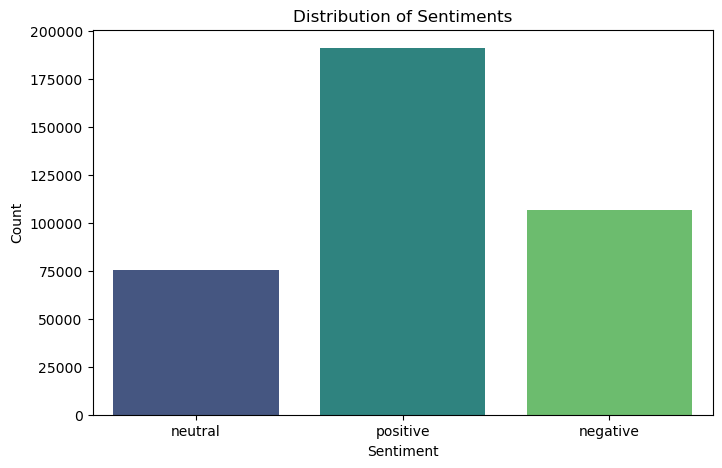

In [7]:
# Distribution of sentiments
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='combined_sentiment', palette='viridis')
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

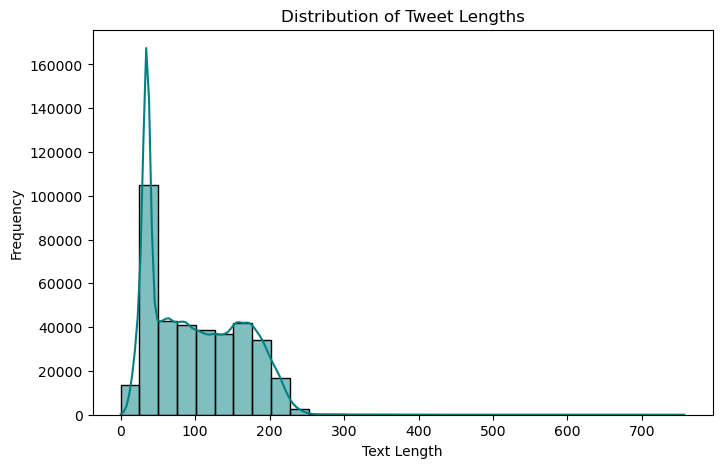

In [8]:
# Plot distribution of text lengths
plt.figure(figsize=(8, 5))
sns.histplot(data['text_length'], bins=30, kde=True, color='teal')
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

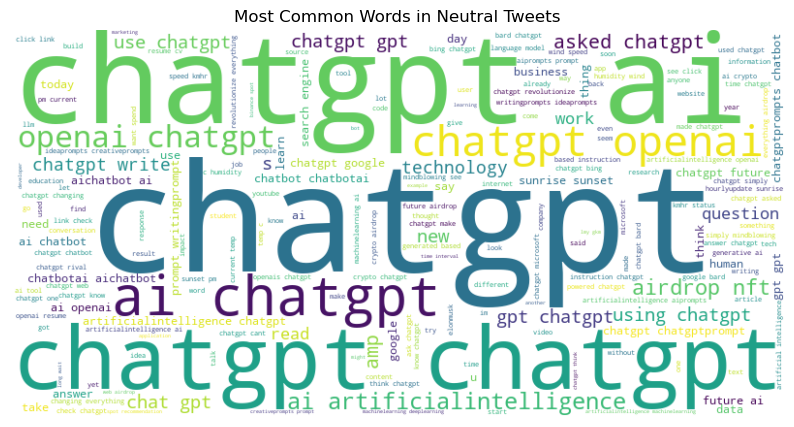

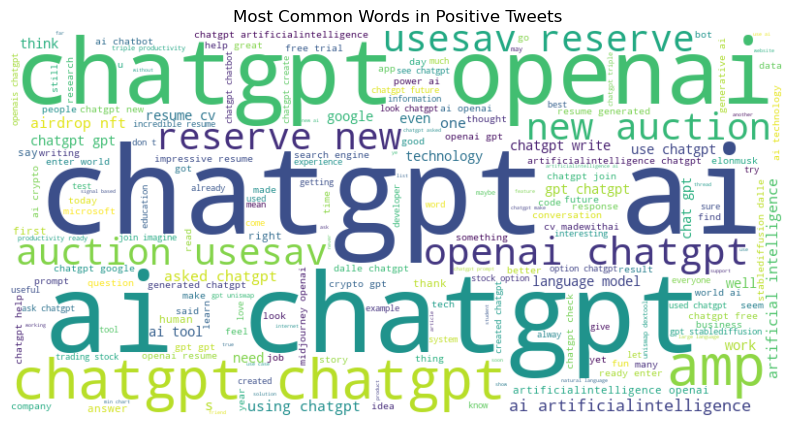

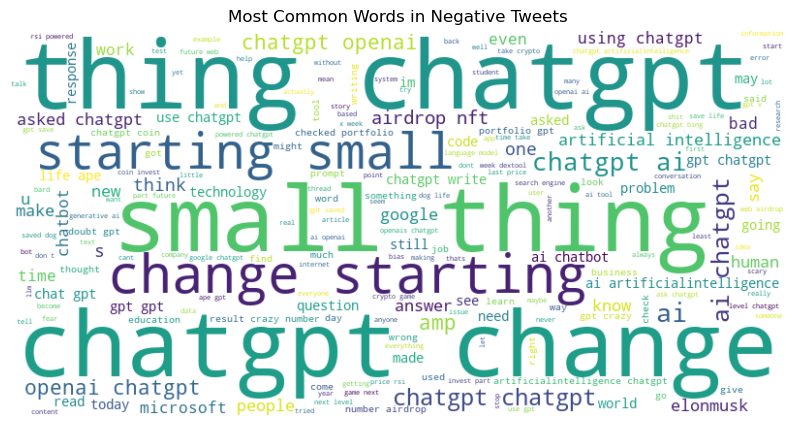

In [9]:
# Generate word clouds for each sentiment
def generate_wordcloud(sentiment):
    text = ' '.join(data[data['combined_sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most Common Words in {sentiment.capitalize()} Tweets")
    plt.show()

for sentiment in data['combined_sentiment'].unique():
    generate_wordcloud(sentiment)

Top 20 Hashtags for Neutral Sentiment:
#ChatGPT: 56499
#AI: 13557
#chatgpt: 11552
#ai: 6122
#OpenAI: 4256
#ArtificialIntelligence: 3524
#openai: 3008
#NFT: 2898
#chatGPT: 2879
#artificialintelligence: 2618
#airdrop: 2180
#Google: 1694
#chatbot: 1690
#MachineLearning: 1470
#Crypto: 1361
#Microsoft: 1321
#technology: 1225
#OpenAIChatGPT: 1065
#ChatGPT,: 1052
#GPT4: 1036


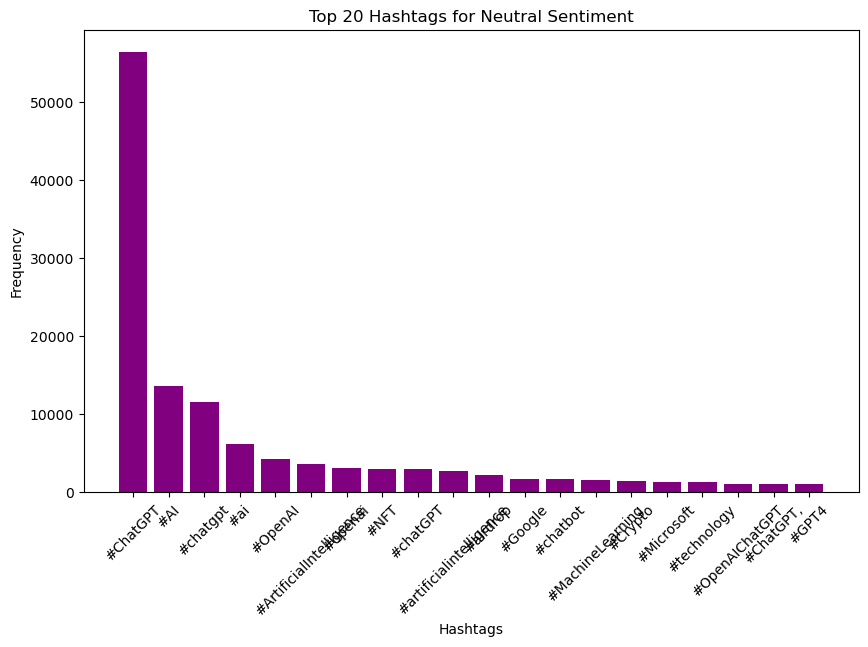

Top 20 Hashtags for Positive Sentiment:
#ChatGPT: 138465
#AI: 37931
#chatgpt: 25300
#ai: 14536
#OpenAI: 11983
#ArtificialIntelligence: 7879
#chatGPT: 7147
#openai: 6755
#NFT: 5960
#artificialintelligence: 5890
#airdrop: 4534
#ChatGPT,: 4399
#technology: 3717
#ChatGPT.: 3659
#GPT4: 3432
#Crypto: 3287
#MachineLearning: 2745
#resume: 2637
#Google: 2573
#CV: 2477


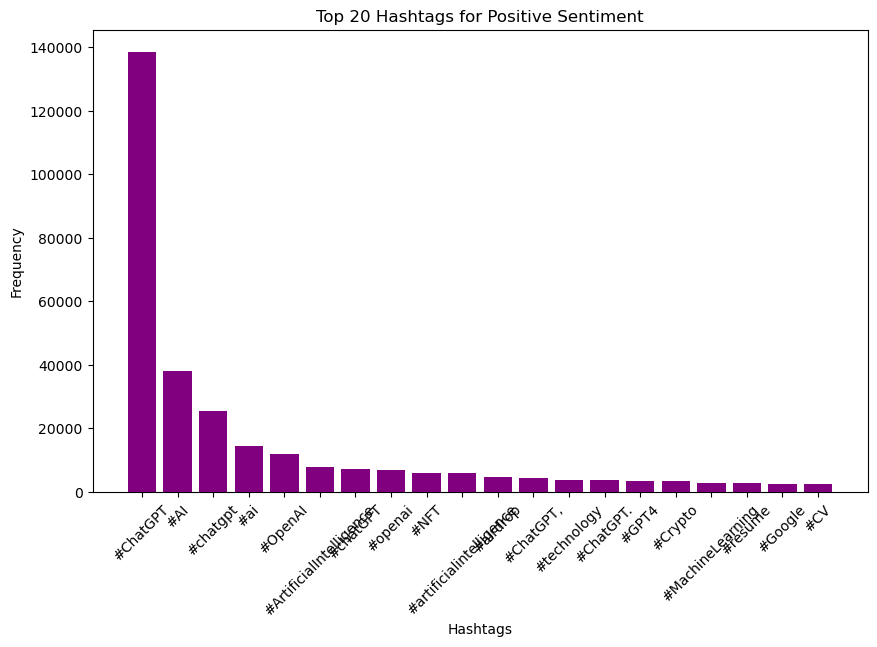

Top 20 Hashtags for Negative Sentiment:
#ChatGPT: 95446
#AI: 8805
#chatgpt: 5436
#OpenAI: 2528
#ai: 2452
#GPT4: 2213
#chatGPT: 1929
#openai: 1872
#ArtificialIntelligence: 1804
#NFT: 1639
#airdrop: 1422
#crypto: 1171
#Google: 1038
#ChatGPT,: 902
#ChatGPT.: 827
#Microsoft: 732
#OpenAIChatGPT: 713
#technology: 665
#artificialintelligence: 665
#MachineLearning: 631


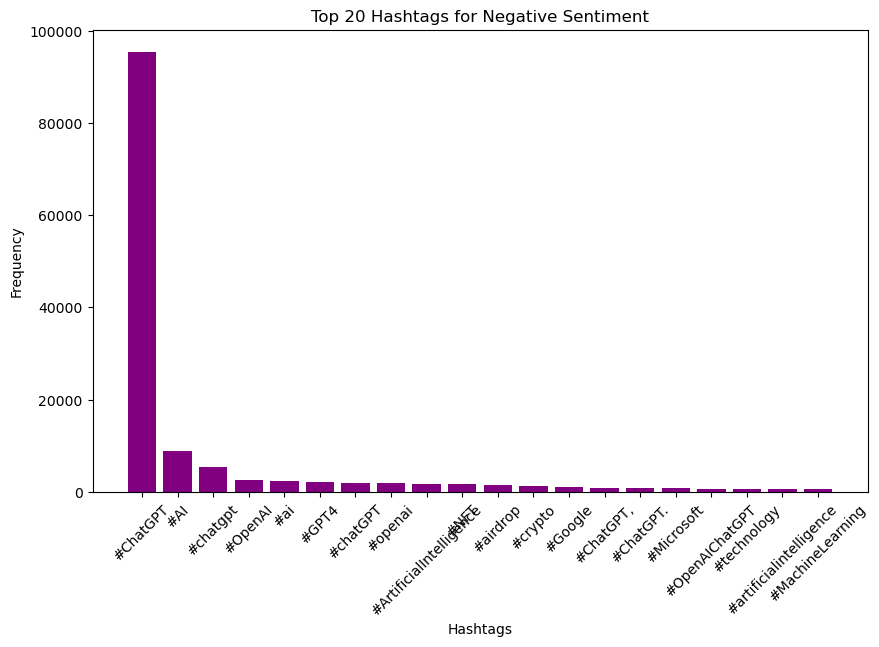

In [10]:
# Extract hashtags
def extract_hashtags(text):
    return [word for word in text.split() if word.startswith('#')]

data['hashtags'] = data['text'].apply(extract_hashtags)

# Top hashtags by sentiment
for sentiment in data['combined_sentiment'].dropna().unique():
    sentiment_data = data[data['combined_sentiment'] == sentiment]
    sentiment_hashtags = [hashtag for hashtags in sentiment_data['hashtags'] for hashtag in hashtags]
    sentiment_hashtag_counts = Counter(sentiment_hashtags)
    top_hashtags = sentiment_hashtag_counts.most_common(20)
    print(f"Top 20 Hashtags for {sentiment.capitalize()} Sentiment:")
    for htag, count in top_hashtags:
        print(f"{htag}: {count}")
    plt.figure(figsize=(10, 6))
    plt.bar(*zip(*top_hashtags), color='purple')
    plt.title(f"Top 20 Hashtags for {sentiment.capitalize()} Sentiment")
    plt.xlabel("Hashtags")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

In [11]:
# Store top_hashtags from a known sentiment (e.g. neutral) for later use if needed:
neutral_data = data[data['combined_sentiment'] == 'neutral']
neutral_hashtags = [hashtag for hashtags in neutral_data['hashtags'] for hashtag in hashtags]
neutral_hashtag_counts = Counter(neutral_hashtags)
top_hashtags_for_ai = neutral_hashtag_counts.most_common(20)  # Arbitrary choice

Top 20 AI-related Keywords for Neutral Sentiment:
chatgpt: 91870
ai: 32019
gpt: 8222
model: 1509
learning: 810
llm: 569
nlp: 556
machine: 463
artificial: 455
intelligence: 447
elon: 415
network: 179
deep: 172
transformer: 151
neural: 80
bert: 26


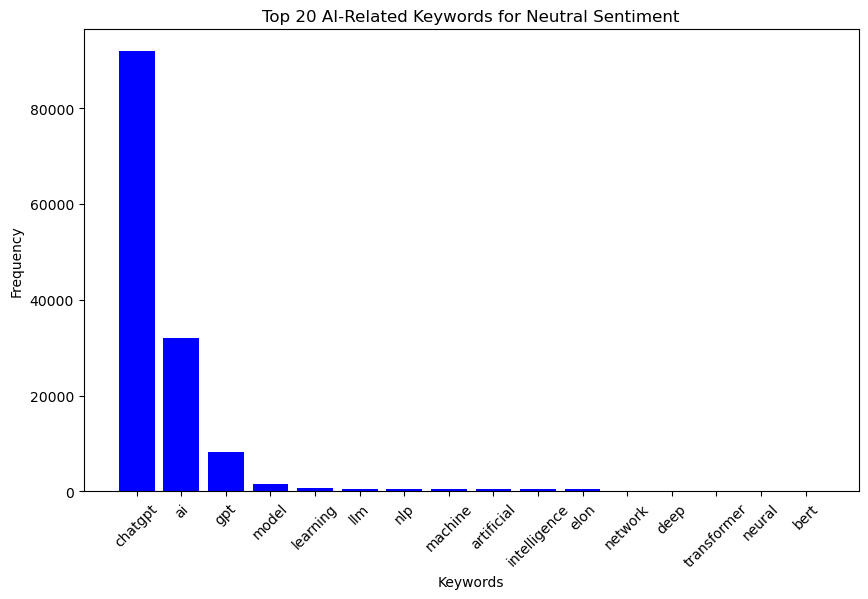

Top 20 AI-related Keywords for Positive Sentiment:
chatgpt: 229059
ai: 94350
gpt: 25112
model: 6505
intelligence: 5312
artificial: 4170
learning: 3659
llm: 1851
machine: 1776
nlp: 1488
elon: 748
network: 711
deep: 642
transformer: 371
neural: 245
bert: 63


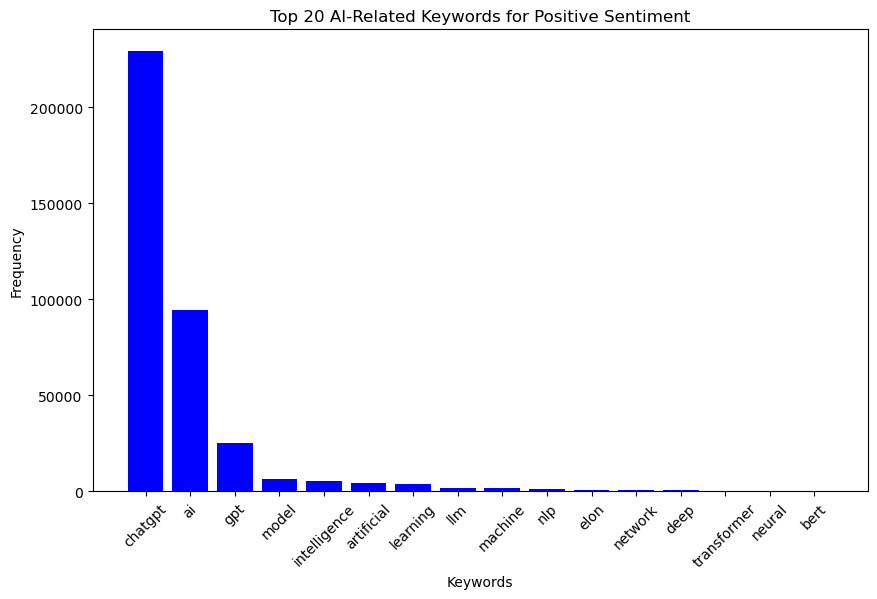

Top 20 AI-related Keywords for Negative Sentiment:
chatgpt: 116022
ai: 20366
gpt: 7834
artificial: 1298
intelligence: 1179
model: 1026
learning: 565
machine: 410
llm: 376
elon: 278
network: 232
nlp: 208
deep: 136
transformer: 70
neural: 47
bert: 7


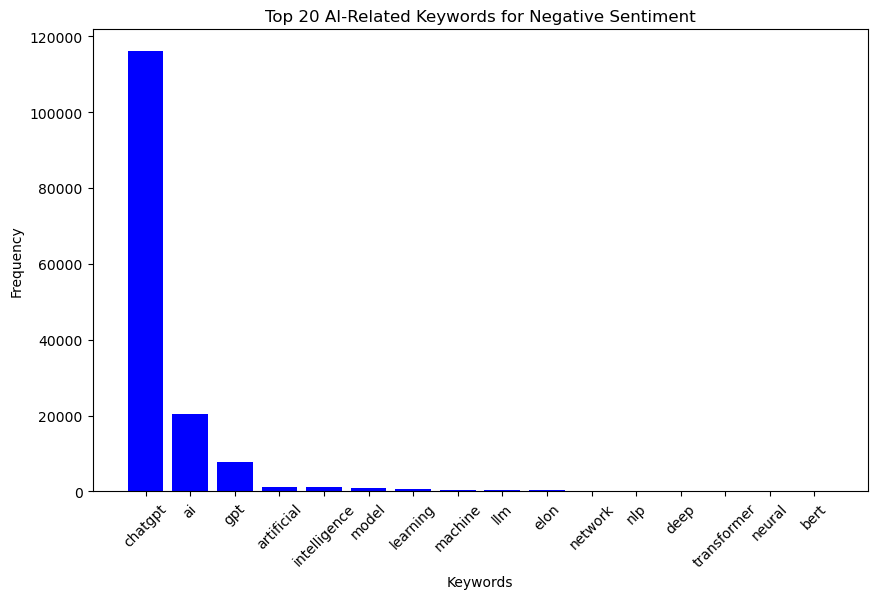

In [12]:
# Define a more robust dictionary of AI-related keywords
# (Add or remove terms based on your domain knowledge)
# AI-related keywords
ai_terms = {
    'artificial', 'intelligence', 'machine', 'learning', 'deep', 'neural', 'network',
    'nlp', 'transformer', 'model', 'chatgpt', 'gpt', 'bert', 'llm', 'ai', 'elon'
}

def extract_ai_keywords(text):
    words = text.lower().split()
    return [word for word in words if word in ai_terms]

data['ai_keywords'] = data['cleaned_text'].apply(extract_ai_keywords)

# Top AI-related keywords per sentiment
for sentiment in data['combined_sentiment'].dropna().unique():
    sentiment_data = data[data['combined_sentiment'] == sentiment]
    sentiment_keywords = [kw for keyword_list in sentiment_data['ai_keywords'] for kw in keyword_list]
    sentiment_keyword_counts = Counter(sentiment_keywords)
    top_ai_keywords = sentiment_keyword_counts.most_common(20)
    print(f"Top 20 AI-related Keywords for {sentiment.capitalize()} Sentiment:")
    for kw, count in top_ai_keywords:
        print(f"{kw}: {count}")
    plt.figure(figsize=(10, 6))
    plt.bar(*zip(*top_ai_keywords), color='blue')
    plt.title(f"Top 20 AI-Related Keywords for {sentiment.capitalize()} Sentiment")
    plt.xlabel("Keywords")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

In [13]:
def extract_relevant_words(text_series, common_words):
    all_words = Counter(word for text in text_series for word in text.split())
    filtered_words = {word: count for word, count in all_words.items()
                      if len(word) > 2 and count > 1 and word not in common_words}
    return pd.Series(filtered_words).sort_values(ascending=False)

def create_treemap(words_series, common_words, title):
    unique_words = words_series.drop(labels=common_words, errors='ignore')[:30]
    unique_words = unique_words.rename_axis('Unique Words').reset_index(name='count')
    fig = px.treemap(unique_words, path=['Unique Words'], values='count', title=title)
    fig.show()

positive_tweet = data[data['combined_sentiment'] == 'positive']
negative_tweet = data[data['combined_sentiment'] == 'negative']
neutral_tweet = data[data['combined_sentiment'] == 'neutral']

all_positive_words = extract_relevant_words(positive_tweet['cleaned_text'], set())
all_negative_words = extract_relevant_words(negative_tweet['cleaned_text'], set())
all_neutral_words = extract_relevant_words(neutral_tweet['cleaned_text'], set())

create_treemap(all_positive_words, [], 'Top 30 Unique Words in Positive Tweets')
create_treemap(all_negative_words, [], 'Top 30 Unique Words in Negative Tweets')
create_treemap(all_neutral_words, [], 'Top 30 Unique Words in Neutral Tweets')

Top 10 Accounts with the Highest Followers for Neutral Sentiment:
                    user_name  user_followers
557424             Bill Maher      10947335.0
60729       Subramanian Swamy      10913966.0
932                 TIMES NOW      10320242.0
527777  People's Daily, China       6728655.0
29752                ARY NEWS       5376366.0
511320          New Scientist       4312236.0
7448               BlackBerry       3989425.0
702029              Dane Cook       2730332.0
476471  Trust - Crypto Wallet       2290311.0
3292                Firstpost       2118867.0


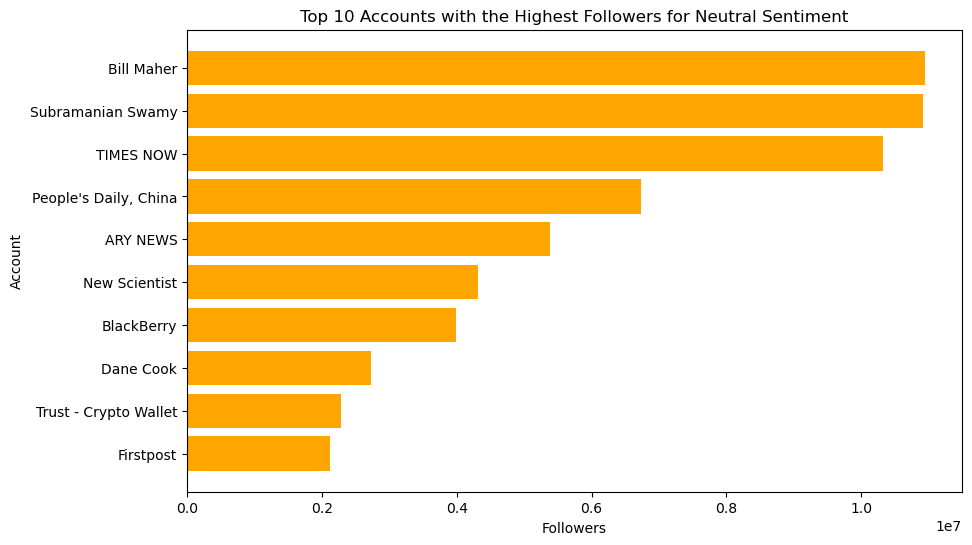

Top 10 Accounts with the Highest Followers for Positive Sentiment:
                    user_name  user_followers
15008                    NDTV      17728427.0
18167      The Times Of India      14684078.0
521991             TechCrunch      10291892.0
97322                   WIRED      10183614.0
270           Hindustan Times       8703546.0
59243           CoinMarketCap       5829169.0
12670                  News18       4743013.0
526135                 Xiaomi       4389272.0
31046             China Daily       4168998.0
549179  H.E. Justin Sun🇬🇩🇩🇲🔥₮       3436666.0


C:\Users\chris\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 127468 (\N{REGIONAL INDICATOR SYMBOL LETTER G}) missing from current font.

C:\Users\chris\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from current font.

C:\Users\chris\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 127474 (\N{REGIONAL INDICATOR SYMBOL LETTER M}) missing from current font.

C:\Users\chris\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 128293 (\N{FIRE}) missing from current font.



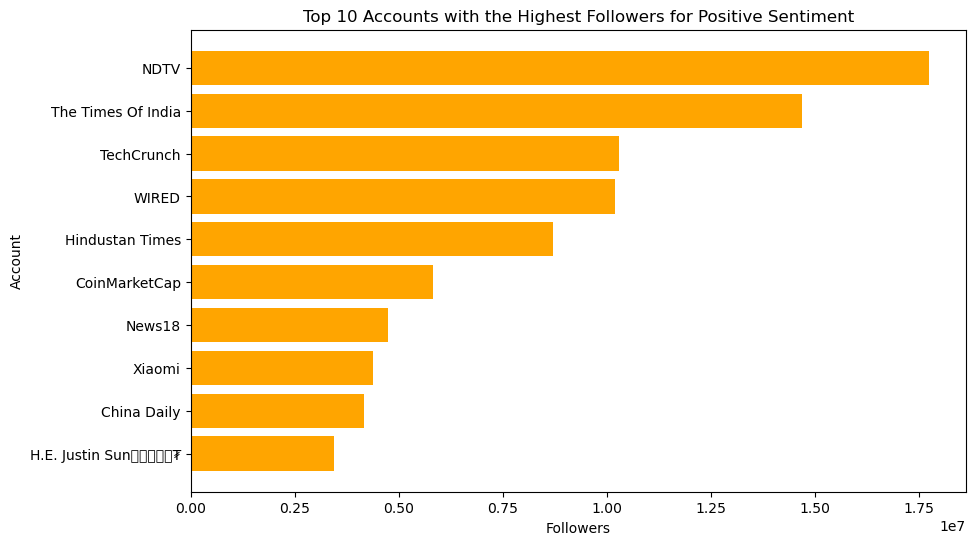

Top 10 Accounts with the Highest Followers for Negative Sentiment:
                 user_name  user_followers
559890    9GAG ❤️ Memeland      16850524.0
13888                 CGTN      13088407.0
4376             The Hindu       7998817.0
3917            IndiaToday       6256606.0
4123      Zee News English       5642848.0
2175        Economic Times       4324349.0
41139   The Indian Express       4265239.0
476025     The Independent       3626857.0
572923       ARY News Urdu       3188742.0
62005      AFP News Agency       2438527.0


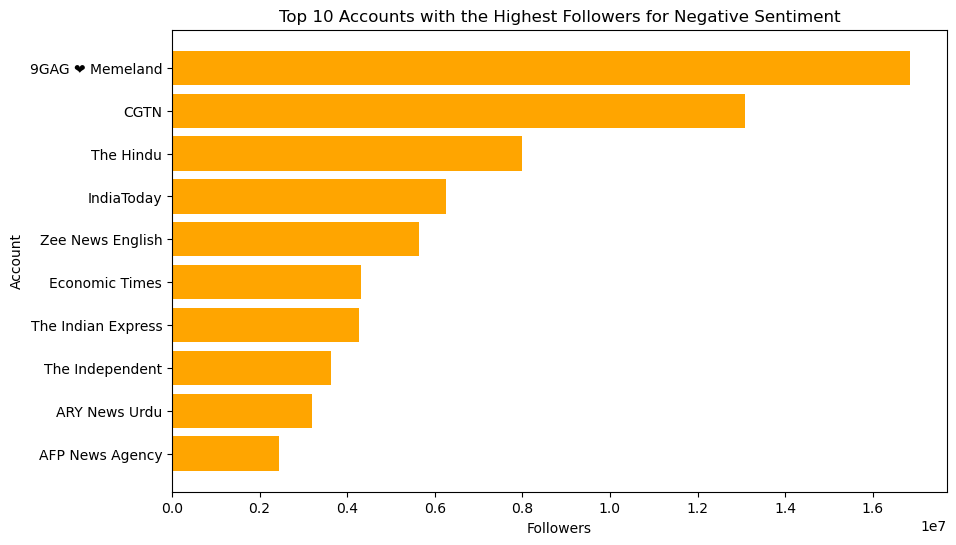

In [14]:
# Analysis of Accounts with Highest Followers for Each Sentiment
# Convert followers count to numeric
# Convert followers and favourites to numeric
data['user_followers'] = pd.to_numeric(data['user_followers'], errors='coerce')
data['user_favourites'] = pd.to_numeric(data['user_favourites'], errors='coerce')

# Remove duplicates based on user_name
data_unique_accounts = data.drop_duplicates(subset=['user_name'])

def get_top_accounts(sentiment):
    sentiment_data = data_unique_accounts[data_unique_accounts['combined_sentiment'] == sentiment]
    top_accounts = sentiment_data[['user_name', 'user_followers']].sort_values(by='user_followers', ascending=False).head(10)
    return top_accounts

for sentiment in data['combined_sentiment'].unique():
    top_accounts = get_top_accounts(sentiment)
    print(f"Top 10 Accounts with the Highest Followers for {sentiment.capitalize()} Sentiment:")
    print(top_accounts)
    plt.figure(figsize=(10, 6))
    plt.barh(top_accounts['user_name'], top_accounts['user_followers'], color='orange')
    plt.title(f"Top 10 Accounts with the Highest Followers for {sentiment.capitalize()} Sentiment")
    plt.xlabel("Followers")
    plt.ylabel("Account")
    plt.gca().invert_yaxis()
    plt.show()

Unique values before conversion: ['False' 'True' nan 'Twitter Web App'
 "['BONE', 'ChatGPT', 'Binance', 'BSC', 'DeFi', 'NFT']"
 '2023-02-22 16:37:55+00:00' 'Twitter for Android'
 "['AI', 'AGI', 'agent', 'nft', 'ChatGPT']" '2022-12-09 17:08:22+00:00'
 False True]


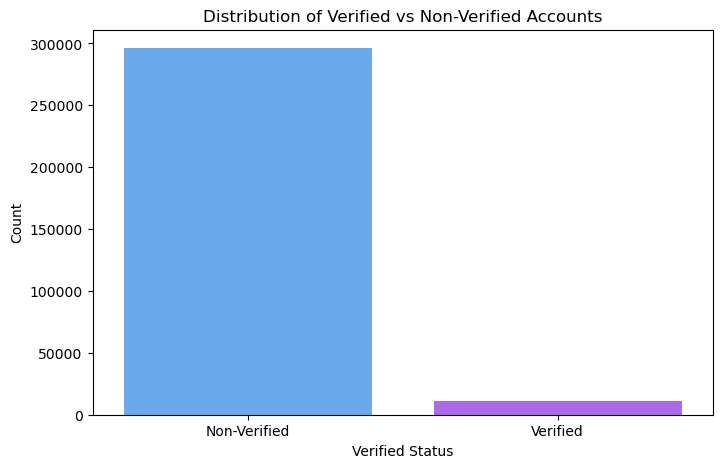

In [15]:
# First, inspect unique values to understand what format they are in
print("Unique values before conversion:", data['user_verified'].unique())
data['user_verified'] = data['user_verified'].astype(str).str.lower().map({'true': True, 'false': False})
data = data.dropna(subset=['user_verified'])

verified_counts = data['user_verified'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(
    x=verified_counts.index,
    y=verified_counts.values,
    palette='cool',
    order=[False, True]
)
plt.title("Distribution of Verified vs Non-Verified Accounts")
plt.xlabel("Verified Status")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['Non-Verified', 'Verified'])
plt.show()

Sentiment counts by verification status:


combined_sentiment  negative  neutral  positive
user_verified                                  
False                  44516    72977    178793
True                    1889     2719      6203

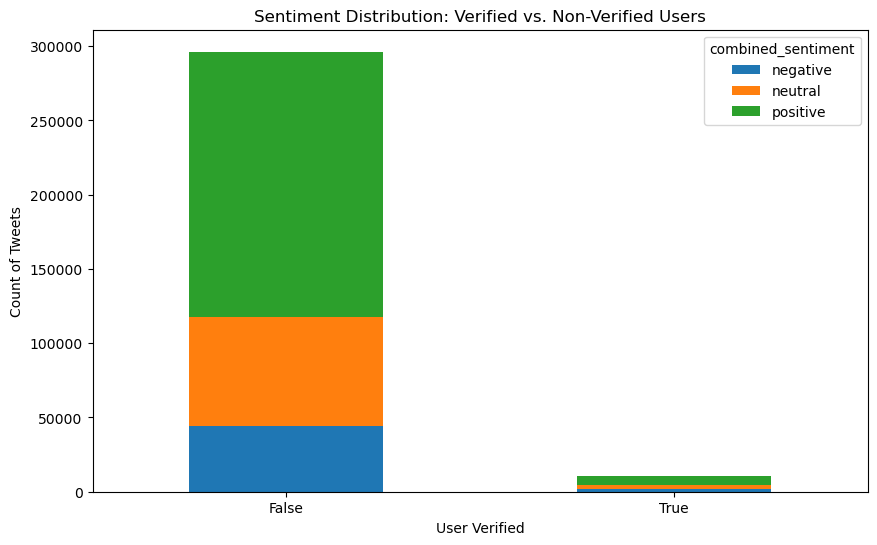

In [16]:
# Compare sentiment or topic distribution for verified vs. non-verified accounts

verified_counts = data.groupby(['user_verified', 'combined_sentiment']).size().unstack(fill_value=0)
print("Sentiment counts by verification status:")
display(verified_counts)

verified_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Sentiment Distribution: Verified vs. Non-Verified Users")
plt.xlabel("User Verified")
plt.ylabel("Count of Tweets")
plt.xticks(rotation=0)
plt.show()

Top 10 Locations for Neutral Sentiment:
India                1542
United States        1218
London, England       509
Global                499
London                465
New Delhi, India      451
Los Angeles, CA       432
Sofia                 426
USA                   388
San Francisco, CA     380
Name: user_location, dtype: int64


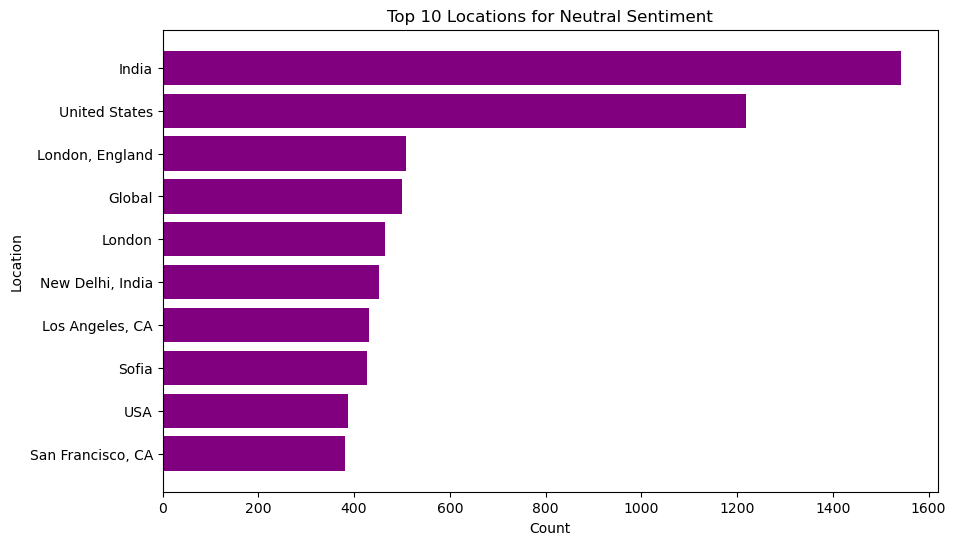

Top 10 Locations for Positive Sentiment:
Sofia                4143
India                2853
United States        2117
Global               1424
London, England      1397
London               1191
San Francisco, CA    1053
New York, NY          940
USA                   904
United Kingdom        894
Name: user_location, dtype: int64


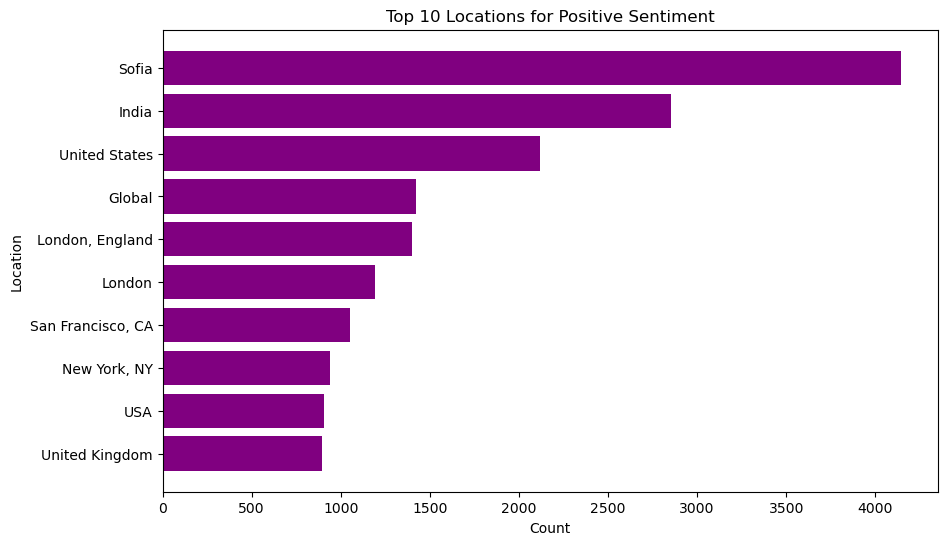

Top 10 Locations for Negative Sentiment:
India               784
United States       658
London, England     364
London              301
USA                 290
Global              286
New York, NY        229
New Delhi, India    227
Metaverse           219
Los Angeles, CA     218
Name: user_location, dtype: int64


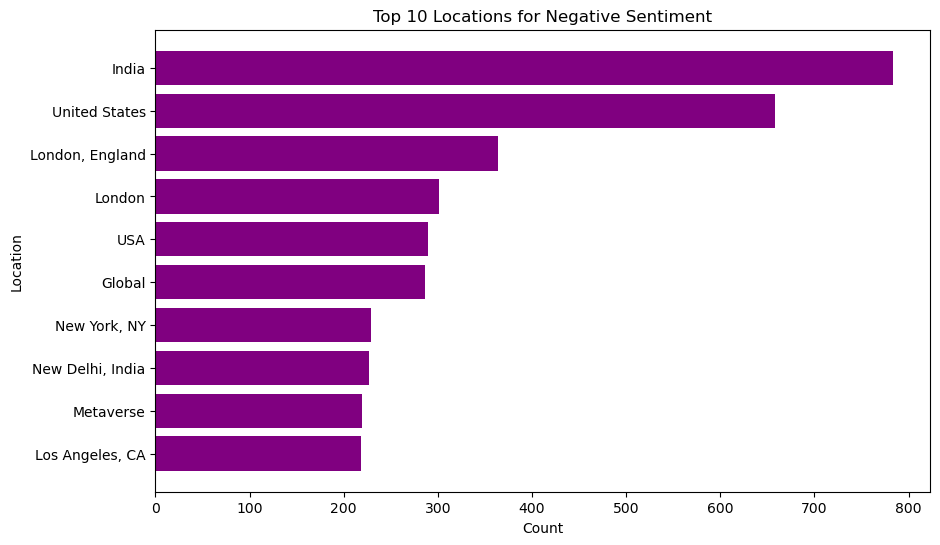

In [17]:
# Function to get top 10 locations for each sentiment
def get_top_locations(sentiment):
    sentiment_data = data[data['combined_sentiment'] == sentiment]
    top_locations = sentiment_data['user_location'].value_counts().head(10)
    return top_locations

for sentiment in data['combined_sentiment'].dropna().unique():
    top_locs = get_top_locations(sentiment)
    print(f"Top 10 Locations for {sentiment.capitalize()} Sentiment:")
    print(top_locs)
    plt.figure(figsize=(10, 6))
    plt.barh(top_locs.index, top_locs.values, color='purple')
    plt.title(f"Top 10 Locations for {sentiment.capitalize()} Sentiment")
    plt.xlabel("Count")
    plt.ylabel("Location")
    plt.gca().invert_yaxis()
    plt.show()

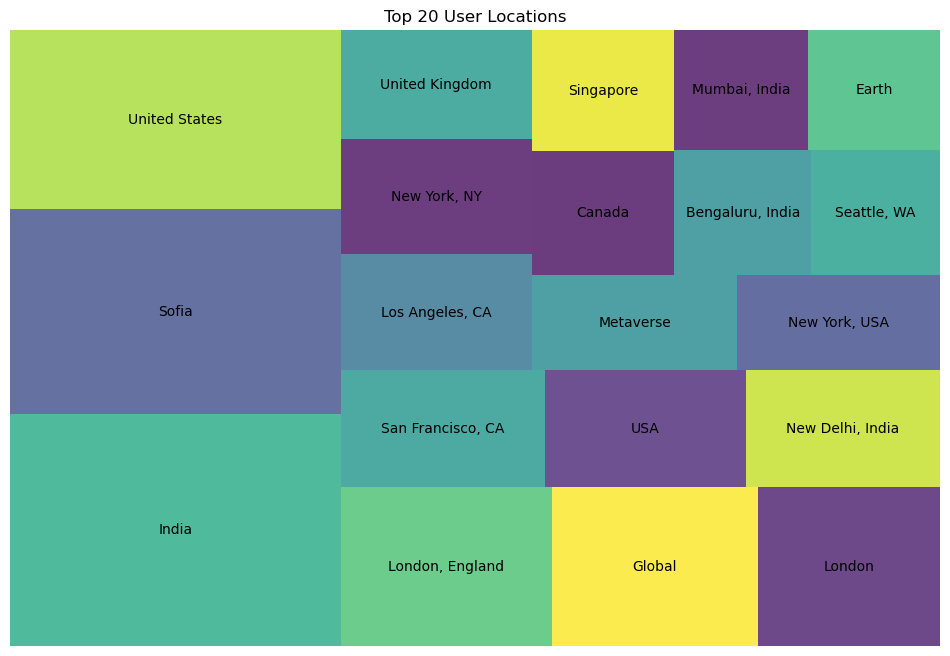

In [18]:
import squarify

# Treemap for Unique User Locations (Overall)
unique_locations_data = data['user_location'].value_counts().head(20)
plt.figure(figsize=(12, 8))
squarify.plot(sizes=unique_locations_data.values, label=unique_locations_data.index, alpha=.8)
plt.title("Top 20 User Locations")
plt.axis('off')
plt.show()

Top 10 Tweet Sources for Neutral Sentiment:
Twitter Web App        34814
Twitter for iPhone     13364
Twitter for Android    12159
Buffer                  1589
TweetDeck               1319
Hootsuite Inc.          1099
LinkedIn                 886
Twitter for iPad         738
Pabbly Connect           686
Zapier.com               534
Name: source, dtype: int64


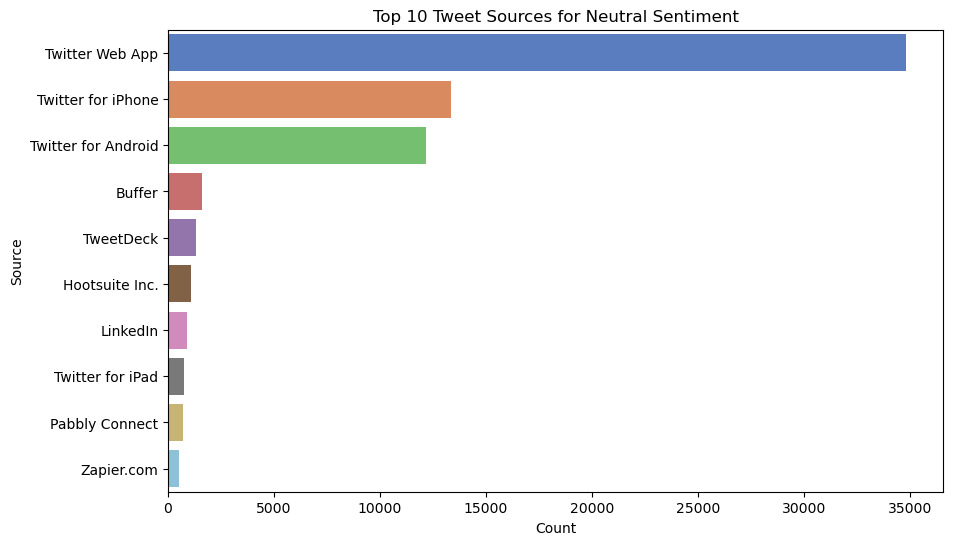

Top 10 Tweet Sources for Positive Sentiment:
Twitter Web App        88285
Twitter for iPhone     30062
Twitter for Android    26626
Zapier.com              5819
Buffer                  3226
IFTTT                   2849
LinkedIn                2814
TweetDeck               2789
Hootsuite Inc.          2463
Twitter for iPad        1774
Name: source, dtype: int64


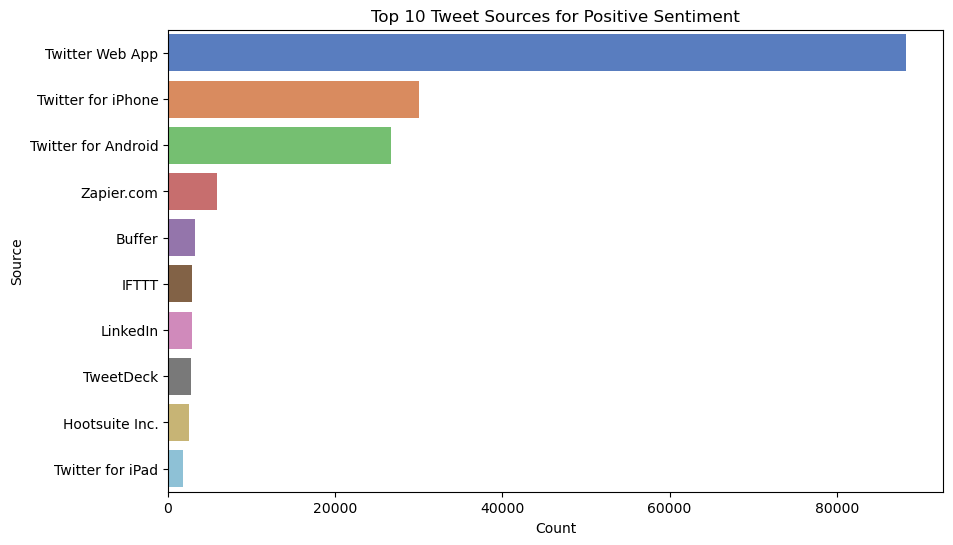

Top 10 Tweet Sources for Negative Sentiment:
Twitter Web App        22298
Twitter for iPhone      8254
Twitter for Android     7808
TweetDeck                834
Buffer                   808
Hootsuite Inc.           548
Twitter for iPad         524
LinkedIn                 508
rsi1                     310
IFTTT                    275
Name: source, dtype: int64


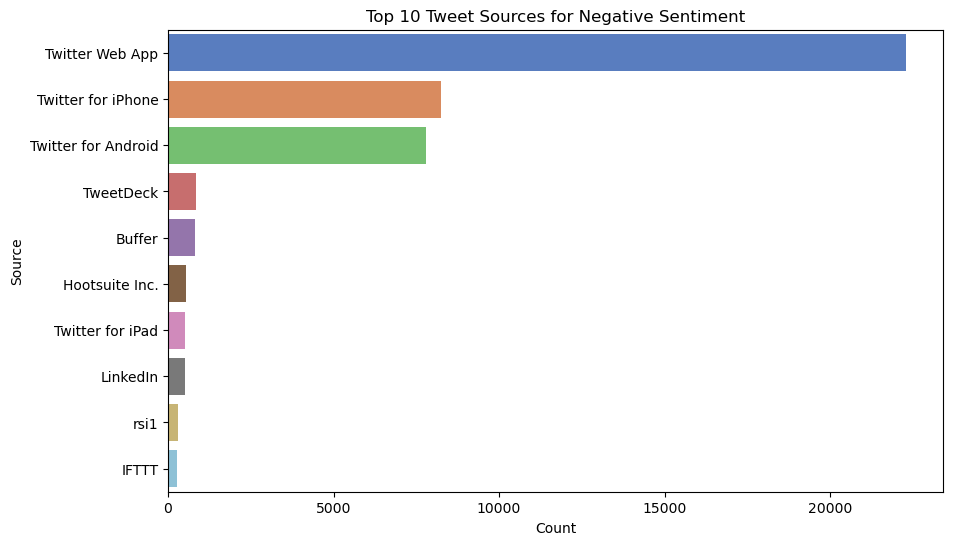

In [19]:
# Function to get top 10 sources for each sentiment
def get_top_sources(sentiment):
    sentiment_data = data[data['combined_sentiment'] == sentiment]
    top_sources = sentiment_data['source'].value_counts().head(10)
    return top_sources

for sentiment in data['combined_sentiment'].dropna().unique():
    top_src = get_top_sources(sentiment)
    print(f"Top 10 Tweet Sources for {sentiment.capitalize()} Sentiment:")
    print(top_src)
    plt.figure(figsize=(10, 6))
    sns.barplot(y=top_src.index, x=top_src.values, palette='muted')
    plt.title(f"Top 10 Tweet Sources for {sentiment.capitalize()} Sentiment")
    plt.xlabel("Count")
    plt.ylabel("Source")
    plt.show()

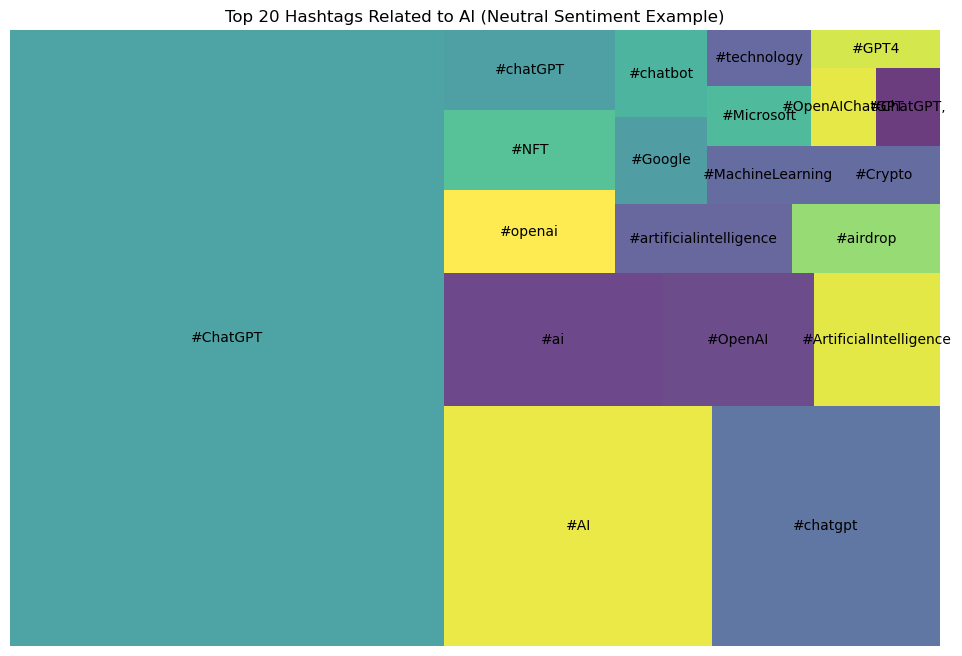

In [20]:
# Use the stored top_hashtags_for_ai instead of top_hashtags directly
plt.figure(figsize=(12, 8))
squarify.plot(sizes=[count for hashtag, count in top_hashtags_for_ai], 
              label=[hashtag for hashtag, count in top_hashtags_for_ai], alpha=.8)
plt.title("Top 20 Hashtags Related to AI (Neutral Sentiment Example)")
plt.axis('off')
plt.show()

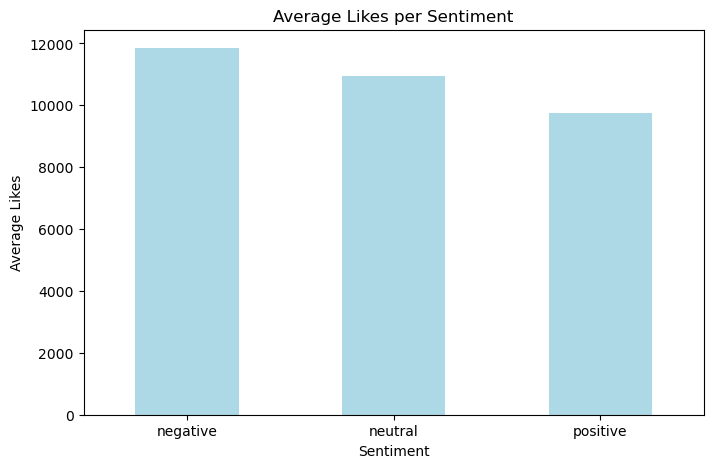


Most liked tweet for Neutral sentiment:
How to replace Siri with ChatGPT AI on your iPhone
#chatgpt #iphone ⁦@Ihnatko⁩ ⁦@alexlindsay⁩  https://t.co/NZhsu4nY76
Likes: 1066130.0

Most liked tweet for Positive sentiment:
Impressive! #MWC2023 #MWC23  #Mobile #AI #OpenAI #ChatGPT #Web3 #IoT #5G @Activithink #SocialMedia #Eventos https://t.co/nQPxFU21xB
Likes: 1420340.0

Most liked tweet for Negative sentiment:
Who wants to have wasted 4 years of University, when you now have Chat GPT-4?! #ChatGPT https://t.co/gLHKhzzLfI
Likes: 1460610.0


In [21]:
avg_likes_by_sentiment = data.groupby('combined_sentiment')['user_favourites'].mean()
plt.figure(figsize=(8, 5))
avg_likes_by_sentiment.plot(kind='bar', color='lightblue')
plt.title("Average Likes per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Likes")
plt.xticks(rotation=0)
plt.show()

# Find and print the text of the tweet with the most likes for each sentiment
unique_sentiments = data['combined_sentiment'].dropna().unique()
for sentiment in unique_sentiments:
    sentiment_data = data[data['combined_sentiment'] == sentiment]
    max_likes = sentiment_data['user_favourites'].max()
    max_likes_tweet = sentiment_data[sentiment_data['user_favourites'] == max_likes]
    if not max_likes_tweet.empty:
        print(f"\nMost liked tweet for {sentiment.capitalize()} sentiment:")
        print(max_likes_tweet['text'].values[0])
        print(f"Likes: {max_likes}")

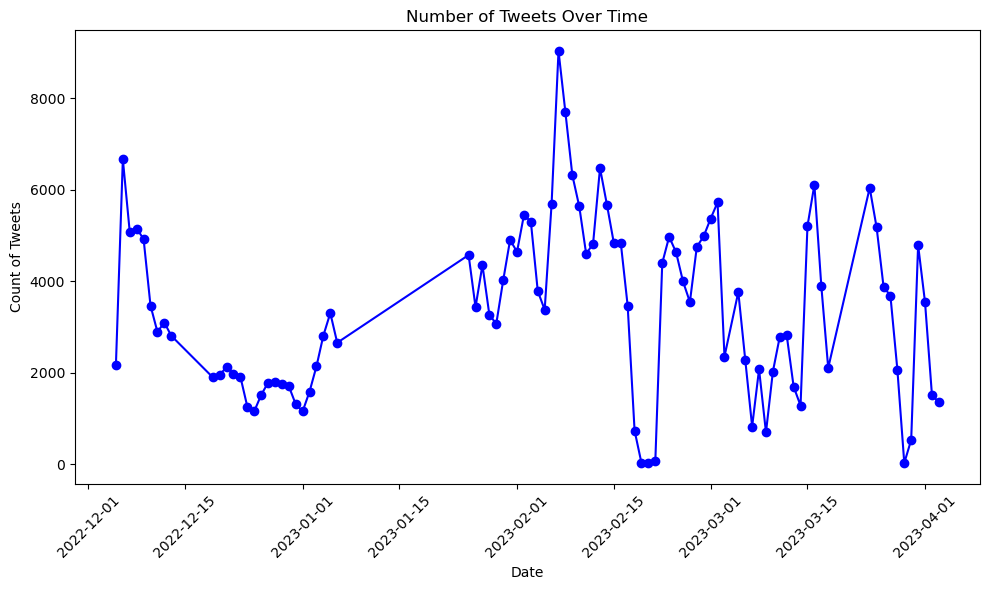

In [22]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')
tweets_per_day = data.groupby(data['date'].dt.date).size()
plt.figure(figsize=(10, 6))
tweets_per_day.plot(kind='line', marker='o', color='blue')
plt.title("Number of Tweets Over Time")
plt.xlabel("Date")
plt.ylabel("Count of Tweets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

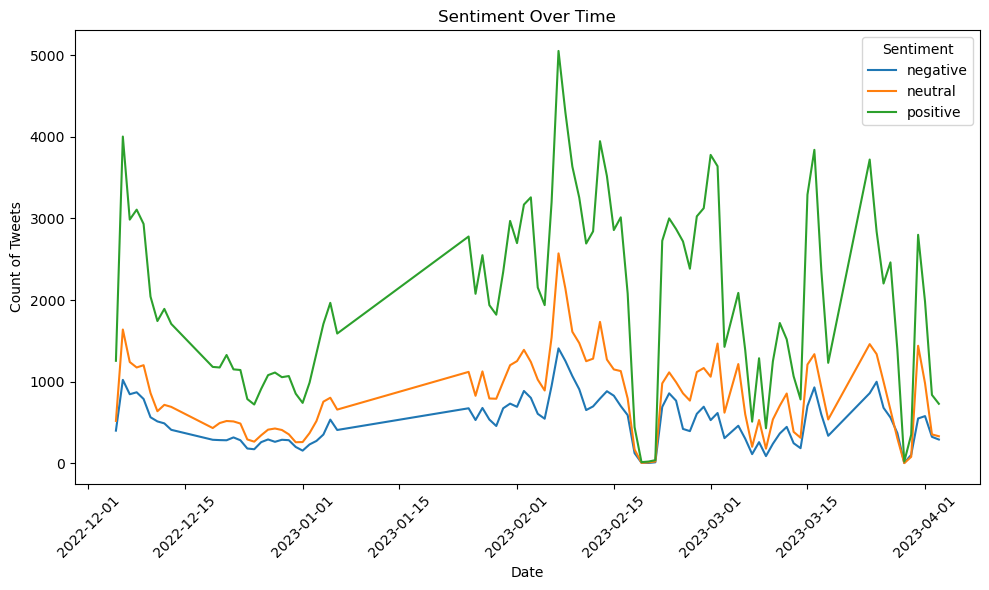

In [24]:
sentiment_over_time = data.groupby([data['date'].dt.date, 'combined_sentiment']).size().unstack(fill_value=0)
sentiment_over_time.plot(figsize=(10, 6))
plt.title("Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Count of Tweets")
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

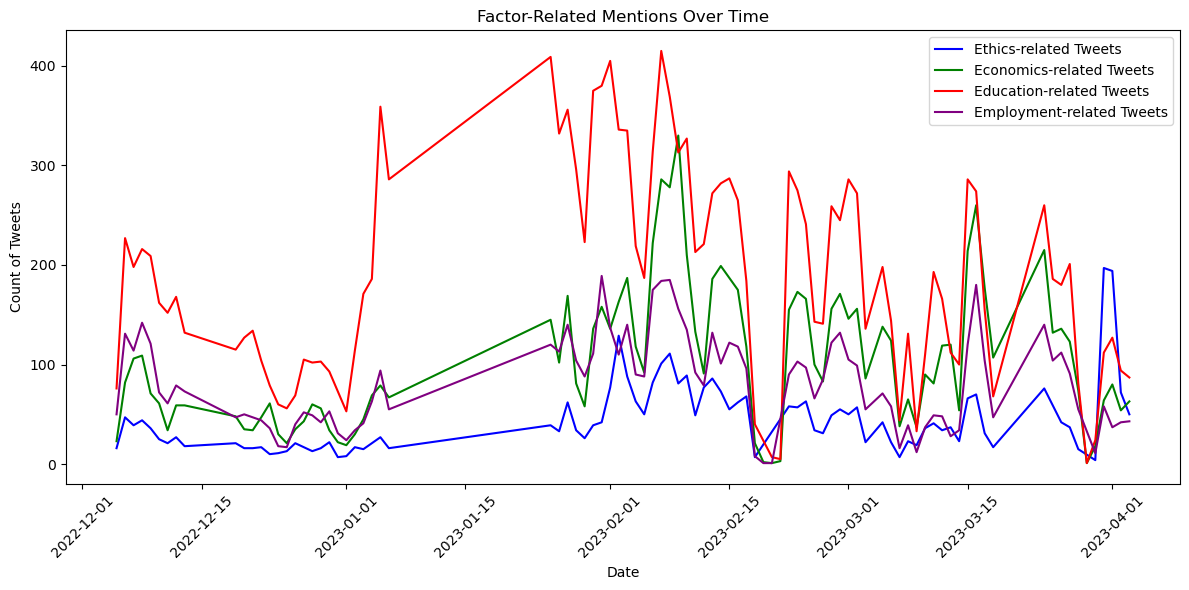

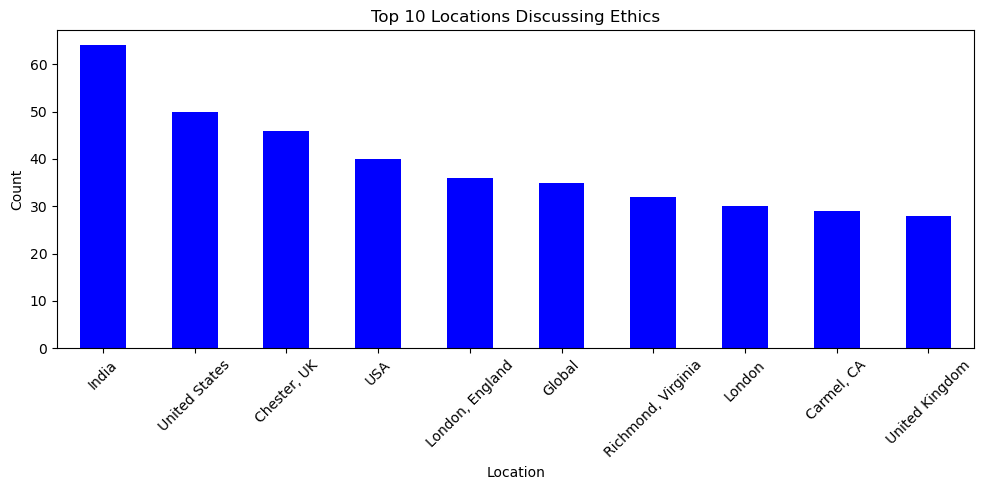

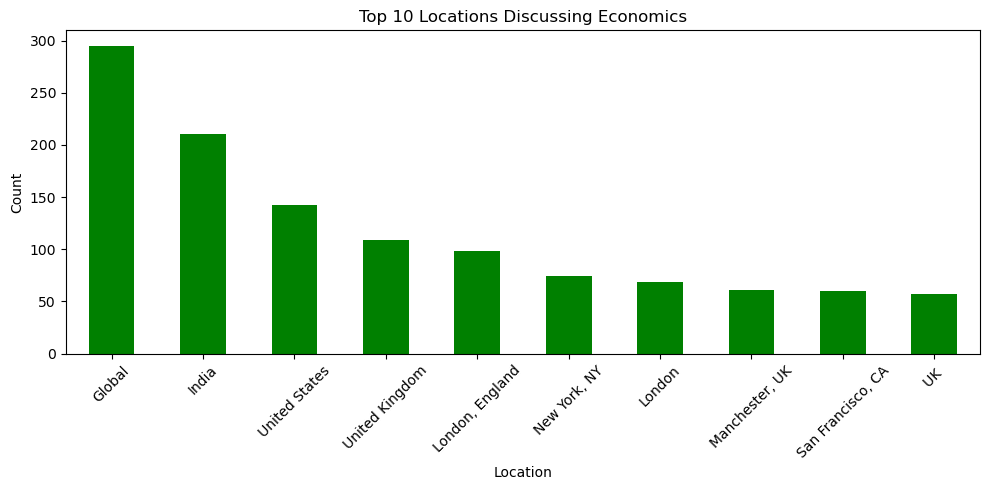

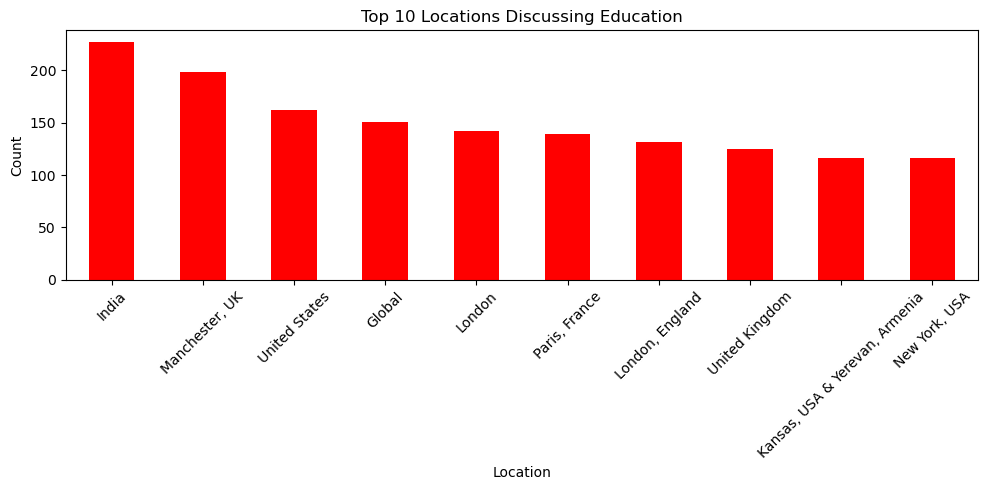

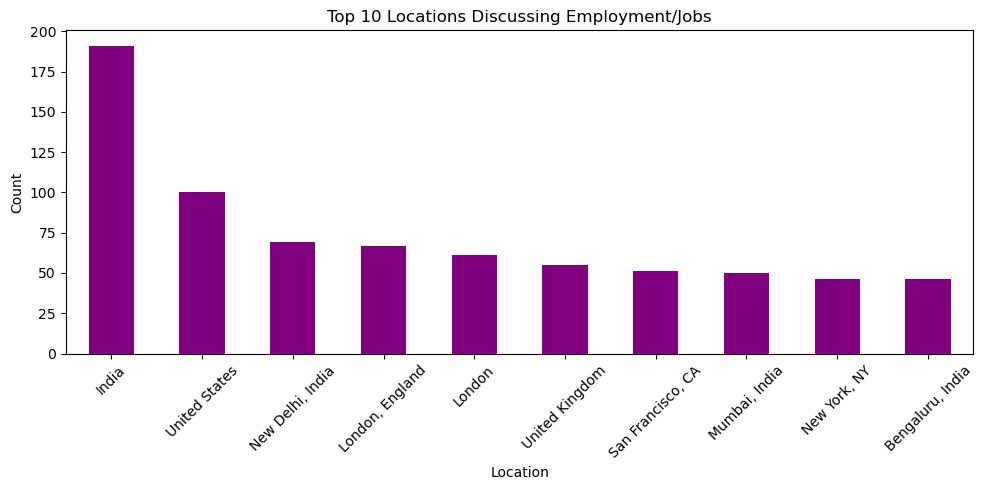

<Figure size 800x600 with 0 Axes>

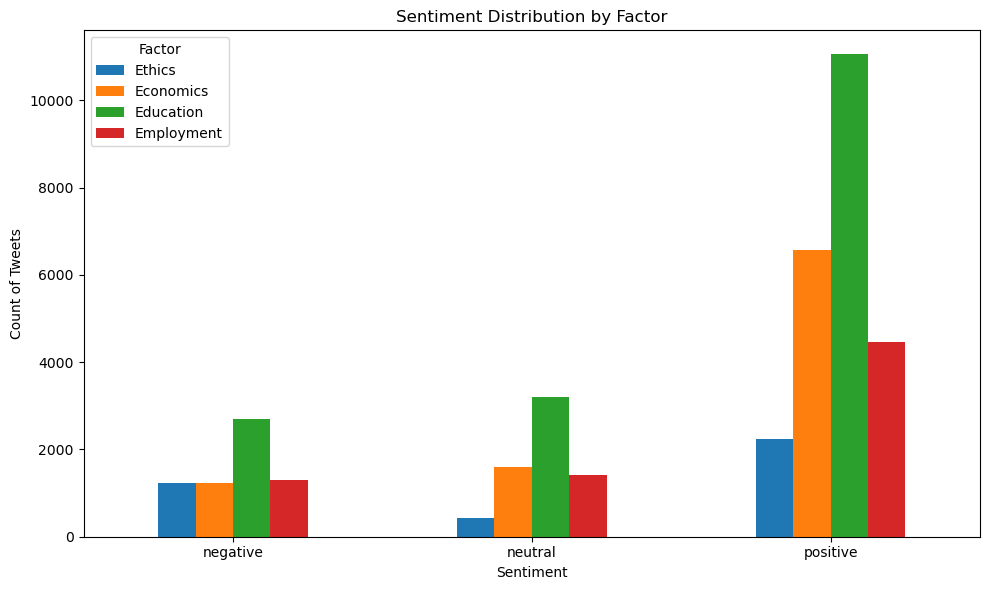

In [25]:
# EDA: Trends and Geographic Patterns for Multiple Factors

# Group by date for each factor
time_ethics = data[data['mentions_ethics']].groupby(data['date'].dt.date).size()
time_economics = data[data['mentions_economics']].groupby(data['date'].dt.date).size()
time_education = data[data['mentions_education']].groupby(data['date'].dt.date).size()
time_employment = data[data['mentions_employment']].groupby(data['date'].dt.date).size()

plt.figure(figsize=(12, 6))
if not time_ethics.empty:
    time_ethics.plot(label='Ethics-related Tweets', color='blue')
if not time_economics.empty:
    time_economics.plot(label='Economics-related Tweets', color='green')
if not time_education.empty:
    time_education.plot(label='Education-related Tweets', color='red')
if not time_employment.empty:
    time_employment.plot(label='Employment-related Tweets', color='purple')

plt.title("Factor-Related Mentions Over Time")
plt.xlabel("Date")
plt.ylabel("Count of Tweets")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

top_ethics_locations = data[data['mentions_ethics']]['user_location'].value_counts().head(10)
top_economics_locations = data[data['mentions_economics']]['user_location'].value_counts().head(10)
top_education_locations = data[data['mentions_education']]['user_location'].value_counts().head(10)
top_employment_locations = data[data['mentions_employment']]['user_location'].value_counts().head(10)

plt.figure(figsize=(10, 5))
top_ethics_locations.plot(kind='bar', color='blue')
plt.title("Top 10 Locations Discussing Ethics")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top_economics_locations.plot(kind='bar', color='green')
plt.title("Top 10 Locations Discussing Economics")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top_education_locations.plot(kind='bar', color='red')
plt.title("Top 10 Locations Discussing Education")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
top_employment_locations.plot(kind='bar', color='purple')
plt.title("Top 10 Locations Discussing Employment/Jobs")
plt.xlabel("Location")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

factors = ['mentions_ethics', 'mentions_economics', 'mentions_education', 'mentions_employment']
factor_labels = ['Ethics', 'Economics', 'Education', 'Employment']
sentiment_counts = {}

for factor, label in zip(factors, factor_labels):
    counts = data[data[factor]].groupby('combined_sentiment').size()
    sentiment_counts[label] = counts

sentiment_df = pd.DataFrame(sentiment_counts).fillna(0)

plt.figure(figsize=(8,6))
sentiment_df.plot(kind='bar', figsize=(10,6))
plt.title("Sentiment Distribution by Factor")
plt.xlabel("Sentiment")
plt.ylabel("Count of Tweets")
plt.xticks(rotation=0)
plt.legend(title='Factor')
plt.tight_layout()
plt.show()

5) Data Analysis/Modeling: 
- Apply suitable data science techniques based on the project goals: 
    - For prediction tasks: Apply machine learning algorithms such as linear regression, decision trees, random forests, or k-means clustering.
    - For exploratory projects such as this one: Perform advanced data visualization, clustering, or correlation analysis.
- Justify the choice of models/analysis methods. 
- Evaluate model performance using appropriate metrics (e.g., accuracy, precision, recall, R², etc.). 

C:\Users\chris\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



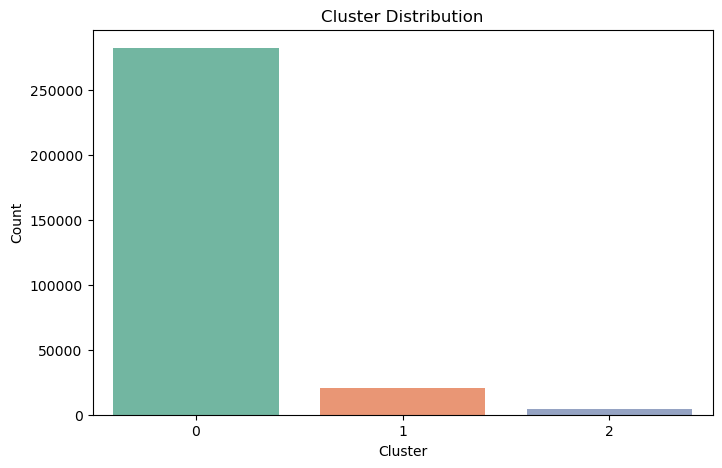

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Ensure that X is defined here
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(data['cleaned_text'])

kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(X)

plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='cluster', palette='Set2')
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

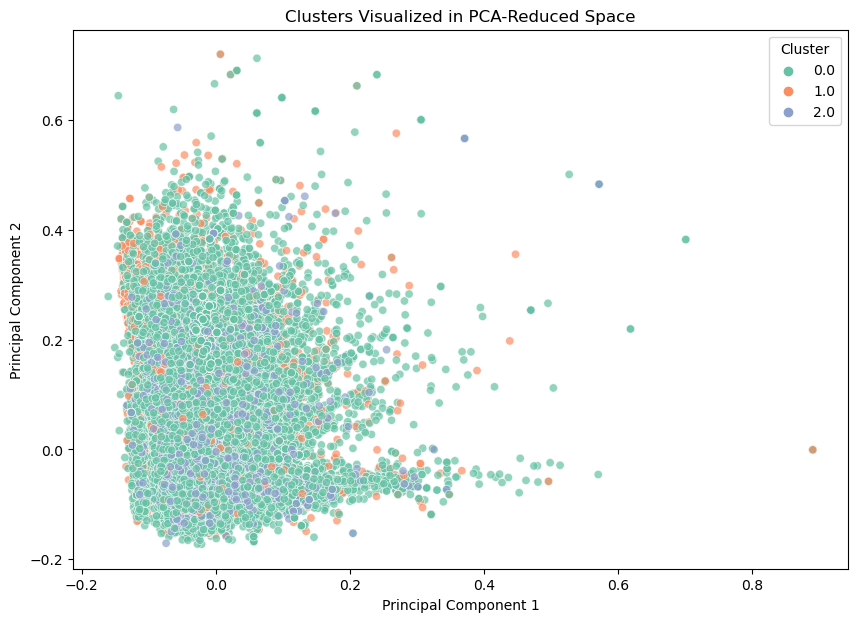

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

cluster_data = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
cluster_data['cluster'] = data['cluster']

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=cluster_data, 
    x='PC1', 
    y='PC2', 
    hue='cluster', 
    palette='Set2', 
    alpha=0.7
)
plt.title("Clusters Visualized in PCA-Reduced Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.show()

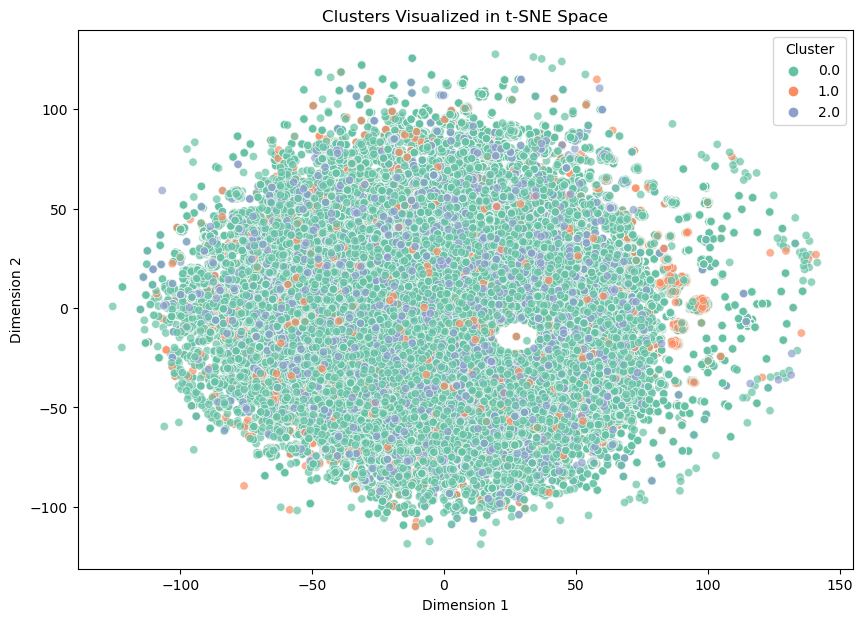

In [29]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X.toarray())

tsne_data = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_data['cluster'] = data['cluster']

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=tsne_data, 
    x='Dim1', 
    y='Dim2', 
    hue='cluster', 
    palette='Set2', 
    alpha=0.7
)
plt.title("Clusters Visualized in t-SNE Space")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title='Cluster')
plt.show()

LDA

In [30]:
# Additional Analysis: Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
topic_matrix = lda.fit_transform(X)

terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx + 1}:", [terms[i] for i in topic.argsort()[-10:]])

Topic 1: ['metaverse', 'web', 'python', 'openai', 'aiart', 'art', 'machinelearning', 'artificialintelligence', 'ai', 'chatgpt']
Topic 2: ['technology', 'tool', 'new', 'language', 'amp', 'model', 'gpt', 'openai', 'ai', 'chatgpt']
Topic 3: ['chatbot', 'new', 'bard', 'search', 'openai', 'bing', 'microsoft', 'ai', 'chatgpt', 'google']
Topic 4: ['make', 'using', 'use', 'like', 'question', 'answer', 'write', 'asked', 'ai', 'chatgpt']
Topic 5: ['artificialintelligence', 'future', 'airdrop', 'crypto', 'openai', 'nft', 'ai', 'resume', 'chatgpt', 'gpt']


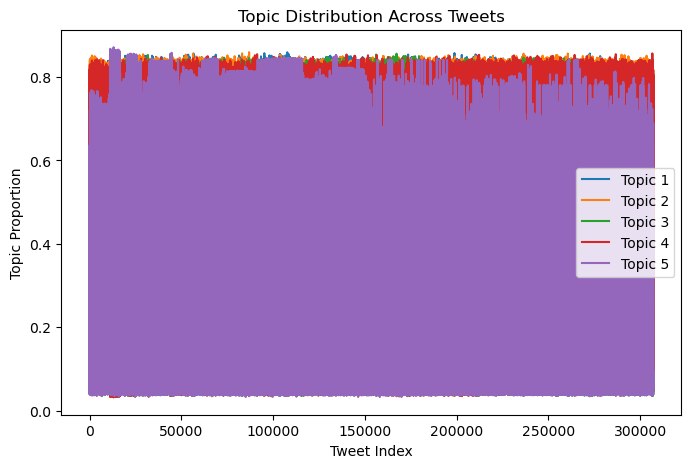

In [31]:
# Visualizing Topic Distribution
plt.figure(figsize=(8, 5))
for i in range(topic_matrix.shape[1]):
    plt.plot(range(len(topic_matrix)), topic_matrix[:, i], label=f'Topic {i+1}')
plt.legend()
plt.title("Topic Distribution Across Tweets")
plt.xlabel("Tweet Index")
plt.ylabel("Topic Proportion")
plt.show()

Sentiment distribution by dominant topic:


combined_sentiment  negative  neutral  positive
dominant_topic                                 
0                       5253    14032     17574
1                       9614    16901     56816
2                      10408    16894     24552
3                      17921    20007     66717
4                       3209     7862     19337

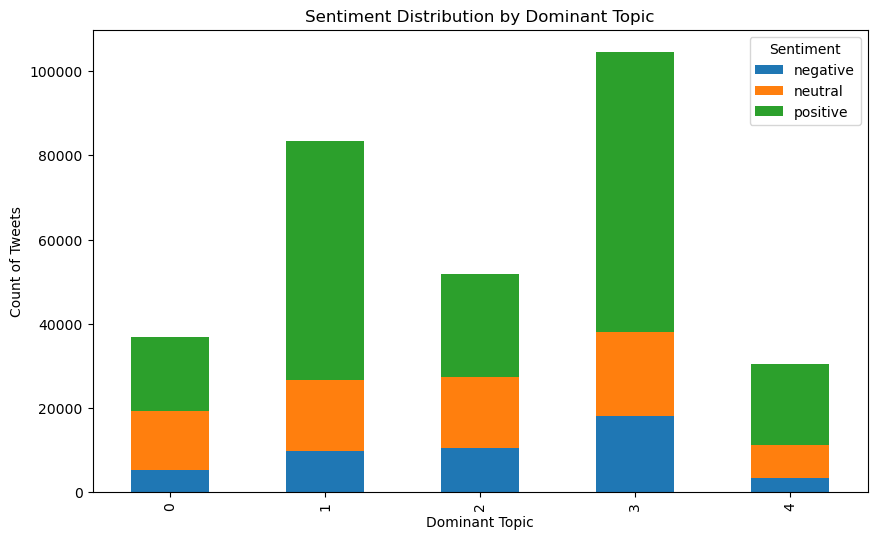

In [32]:
import numpy as np

# After performing LDA and getting 'topic_matrix'
# topic_matrix is of shape (n_samples, n_topics)

# Assign each tweet to the topic with the highest score
dominant_topics = np.argmax(topic_matrix, axis=1)
data['dominant_topic'] = dominant_topics

topic_sentiment_counts = data.groupby(['dominant_topic', 'combined_sentiment']).size().unstack(fill_value=0)
print("Sentiment distribution by dominant topic:")
display(topic_sentiment_counts)

topic_sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Sentiment Distribution by Dominant Topic")
plt.xlabel("Dominant Topic")
plt.ylabel("Count of Tweets")
plt.legend(title="Sentiment")
plt.show()

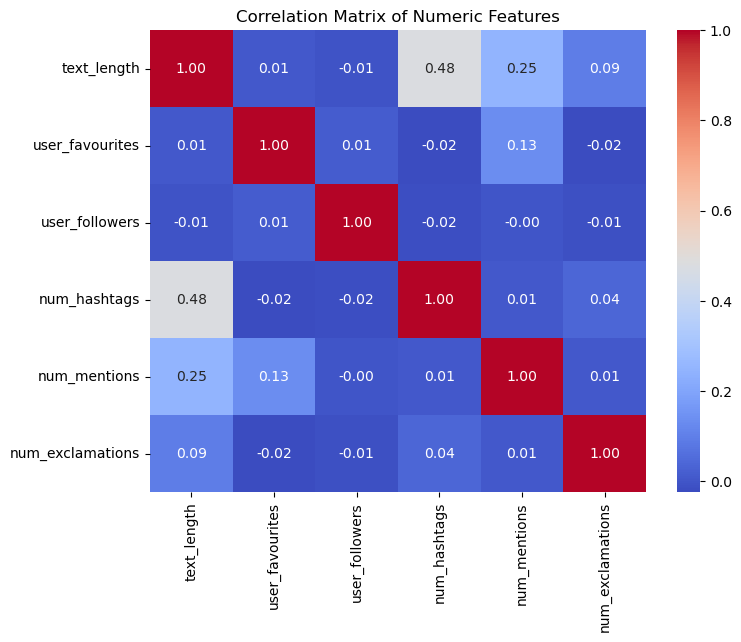

In [33]:
# Example: Correlation Analysis with Numeric Features
# Let's examine correlations between numeric features like text_length, user_favourites, user_followers,
# num_hashtags, and num_mentions. Although sentiment is categorical, we can still see if certain numeric 
# features correlate with each other, hinting at patterns (e.g., do longer tweets have more hashtags?)

numeric_cols = ['text_length', 'user_favourites', 'user_followers', 'num_hashtags', 'num_mentions', 'num_exclamations']
corr_matrix = data[numeric_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [34]:
# Example: Using Silhouette Score to Evaluate Clustering Quality
# If you applied KMeans clustering to the tweet embeddings (X), you can check if the chosen
# number of clusters (e.g., n_clusters=3) was reasonable.

from sklearn.metrics import silhouette_score

labels = data['cluster']
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score for the chosen KMeans clustering: {sil_score:.4f}")

Silhouette Score for the chosen KMeans clustering: 0.0083


In [35]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_ngrams = CountVectorizer(ngram_range=(2,3), stop_words='english', max_features=2000)
X_ngrams = vectorizer_ngrams.fit_transform(data['cleaned_text'])

ngram_freq = X_ngrams.sum(axis=0).A1
ngram_terms = vectorizer_ngrams.get_feature_names_out()
common_ngrams = pd.DataFrame({'ngram': ngram_terms, 'frequency': ngram_freq}).sort_values(by='frequency', ascending=False)
print("Top 20 common bigrams/trigrams:")
display(common_ngrams.head(20))

Top 20 common bigrams/trigrams:


ngram  frequency
394                          chatgpt ai      22570
43                           ai chatgpt      18261
603                      chatgpt openai      13063
1464                     openai chatgpt      11066
22            ai artificialintelligence       9042
169                         airdrop nft       8099
456                     chatgpt chatgpt       7783
261                       asked chatgpt       7012
1884                      using chatgpt       6106
1872                        use chatgpt       5374
229             artificial intelligence       5295
542                         chatgpt gpt       5068
1273                       like chatgpt       4849
378                            chat gpt       4603
711                       chatgpt write       4558
1071                        gpt chatgpt       4039
1238                     language model       3879
134                             ai tool       3869
396   chatgpt ai artificialintelligence       3838
242      artificialintelligence chatgpt       3189

6) Visualization and Interpretation:
- Visualize the results of your analysis with plots, graphs, and charts. 
- Interpret the findings in a non-technical language, clearly explaining what the data reveals about the chosen topic. 
- Use dashboards or interactive visualizations if applicable.

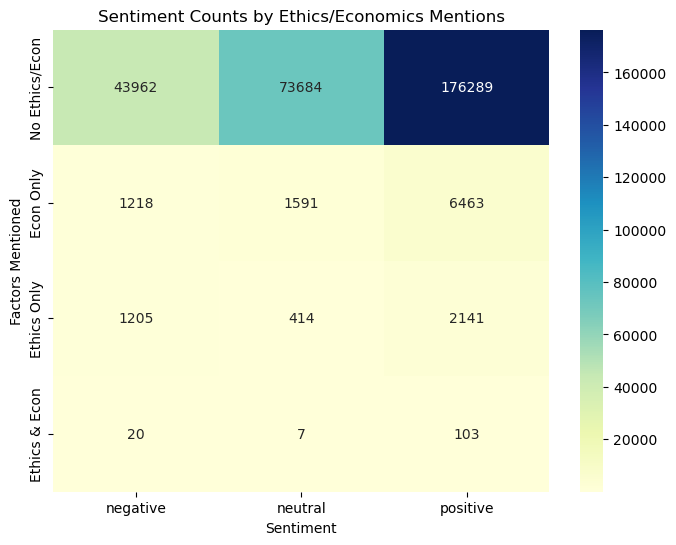

In [36]:
# Visualization and Interpretation
factor_sentiment = data.groupby(['mentions_ethics', 'mentions_economics', 'combined_sentiment']).size().unstack(fill_value=0)
factor_sentiment = factor_sentiment.reindex([(False,False),(False,True),(True,False),(True,True)])
factor_sentiment.index = ['No Ethics/Econ', 'Econ Only', 'Ethics Only', 'Ethics & Econ']

plt.figure(figsize=(8,6))
sns.heatmap(factor_sentiment, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Sentiment Counts by Ethics/Economics Mentions")
plt.xlabel("Sentiment")
plt.ylabel("Factors Mentioned")
plt.show()